In [1]:
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from pathlib import Path
import sys
import psutil
import warnings

from src.dataset import OzeDataset, OzeEvaluationDataset, OzeNPZDataset
from src.utils import npz_check, compute_loss
from src.model import BenchmarkLSTM
from tst import Transformer
from tst.loss import OZELoss

In [2]:
# Show switch to cpu warning
warnings.filterwarnings("default", category=ResourceWarning)

# Parameters

In [3]:
# net_type = "transformer"
net_type = "lstm"

BATCH_SIZE = 100
# NUM_WORKERS = psutil.cpu_count() # Use this to get number of logical processing units
NUM_WORKERS = psutil.cpu_count(logical=False) # Use this to get number of physical Cores
if net_type == "transformer":
    LR = 2e-4
    EPOCHS = 30
    D_MODEL = 64
    # Model parameters
    Q = 8 # Query size
    V = 8 # Value size
    H = 8 # Number of heads
    N = 4 # Number of encoder and decoder to stack
    ATTENTION_SIZE = 12 # Attention window size
    DROPOUT = 0.2 # Dropout rate
    PE = None # Positional encoding
    CHUNK_MODE = None
elif net_type == "lstm":
    LR = 1e-2
    EPOCHS = 5
    HIDDEN_DIM = 100
    NUM_LAYERS = 3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


# Train the benchmark

### Load the dataset

In [4]:
dataset = OzeNPZDataset(dataset_path=npz_check(Path('datasets'), 'dataset'), labels_path="labels.json")
# dataset = OzeDataset(dataset_x_path="datasets/x_train_LsAZgHU.csv", dataset_y_path="datasets/y_train_EFo1WyE.csv", labels_path="labels.json")
K = dataset.time_series_length

# More info about memory pinning here: https://pytorch.org/docs/stable/data.html#memory-pinning
is_cuda = device == torch.device("cuda:0")
num_workers = 0 if is_cuda else NUM_WORKERS
dataloader = DataLoader(dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        pin_memory=is_cuda,
                        num_workers=num_workers)

m, M = dataloader.dataset.m, dataloader.dataset.M

### Load the network

In [5]:
d_input = dataset.get_x_shape()[2]  # From dataset
d_output = dataset.get_y_shape()[2]  # From dataset
if net_type == "lstm":
# Load benchmark network with Adam optimizer and MSE loss function
    net = BenchmarkLSTM(input_dim=d_input, hidden_dim=HIDDEN_DIM, output_dim=d_output, num_layers=NUM_LAYERS).to(device)
    loss_function = nn.MSELoss()
elif net_type == "transformer":
    net = Transformer(d_input, D_MODEL, d_output, Q, V, H, N, attention_size=ATTENTION_SIZE, dropout=DROPOUT, chunk_mode=CHUNK_MODE, pe=PE).to(device)
    loss_function = OZELoss(alpha=0.3)
optimizer = optim.Adam(net.parameters(), lr=LR)

### Train the network

[Epoch   5/5]: 100%|██████████| 7500/7500 [00:22<00:00, 339.49it/s, loss=0.00514]
model exported to model_2020_05_23__175942.pth with loss 0.005141



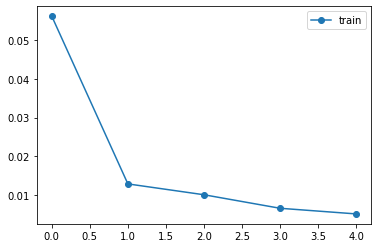

In [6]:
model_save_path = f'model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'

def fit():
    """
    Fits selected network
    """
    loss_best = np.inf
    # Prepare loss history
    hist_loss = np.zeros(EPOCHS)
    for idx_epoch in range(EPOCHS):
        running_loss = 0
        with tqdm(total=len(dataloader.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
            for idx_batch, (inp, out) in enumerate(dataloader):
                optimizer.zero_grad()

                # Propagate input
                net_out = net(inp.to(device))

                # Compute loss
                loss = loss_function(out.to(device), net_out)

                # Backpropagate loss
                loss.backward()

                # Update weights
                optimizer.step()

                running_loss += loss.item()
                pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
                pbar.update(inp.shape[0])

            train_loss = running_loss/len(dataloader)
            pbar.set_postfix({'loss': train_loss})

            hist_loss[idx_epoch] = train_loss

            if train_loss < loss_best:
                train_loss_best = train_loss
                torch.save(net.state_dict(), model_save_path)
    print(f"\nmodel exported to {model_save_path} with loss {train_loss_best:5f}")
    return hist_loss

try:
    hist_loss = fit()
except RuntimeError as err:
    if str(err).startswith('CUDA out of memory.'):
        warnings.warn('\nSwitching device to cpu to workaround CUDA out of memory problem.', ResourceWarning)
        device = torch.device("cpu")
        net = net.to(device)
        dataloader = DataLoader(dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                pin_memory=False,
                                num_workers=NUM_WORKERS)
        hist_loss = fit()
    else:
        sys.exit()

plt.plot(hist_loss, 'o-', label='train')
plt.legend()

### Plot the results for a training example

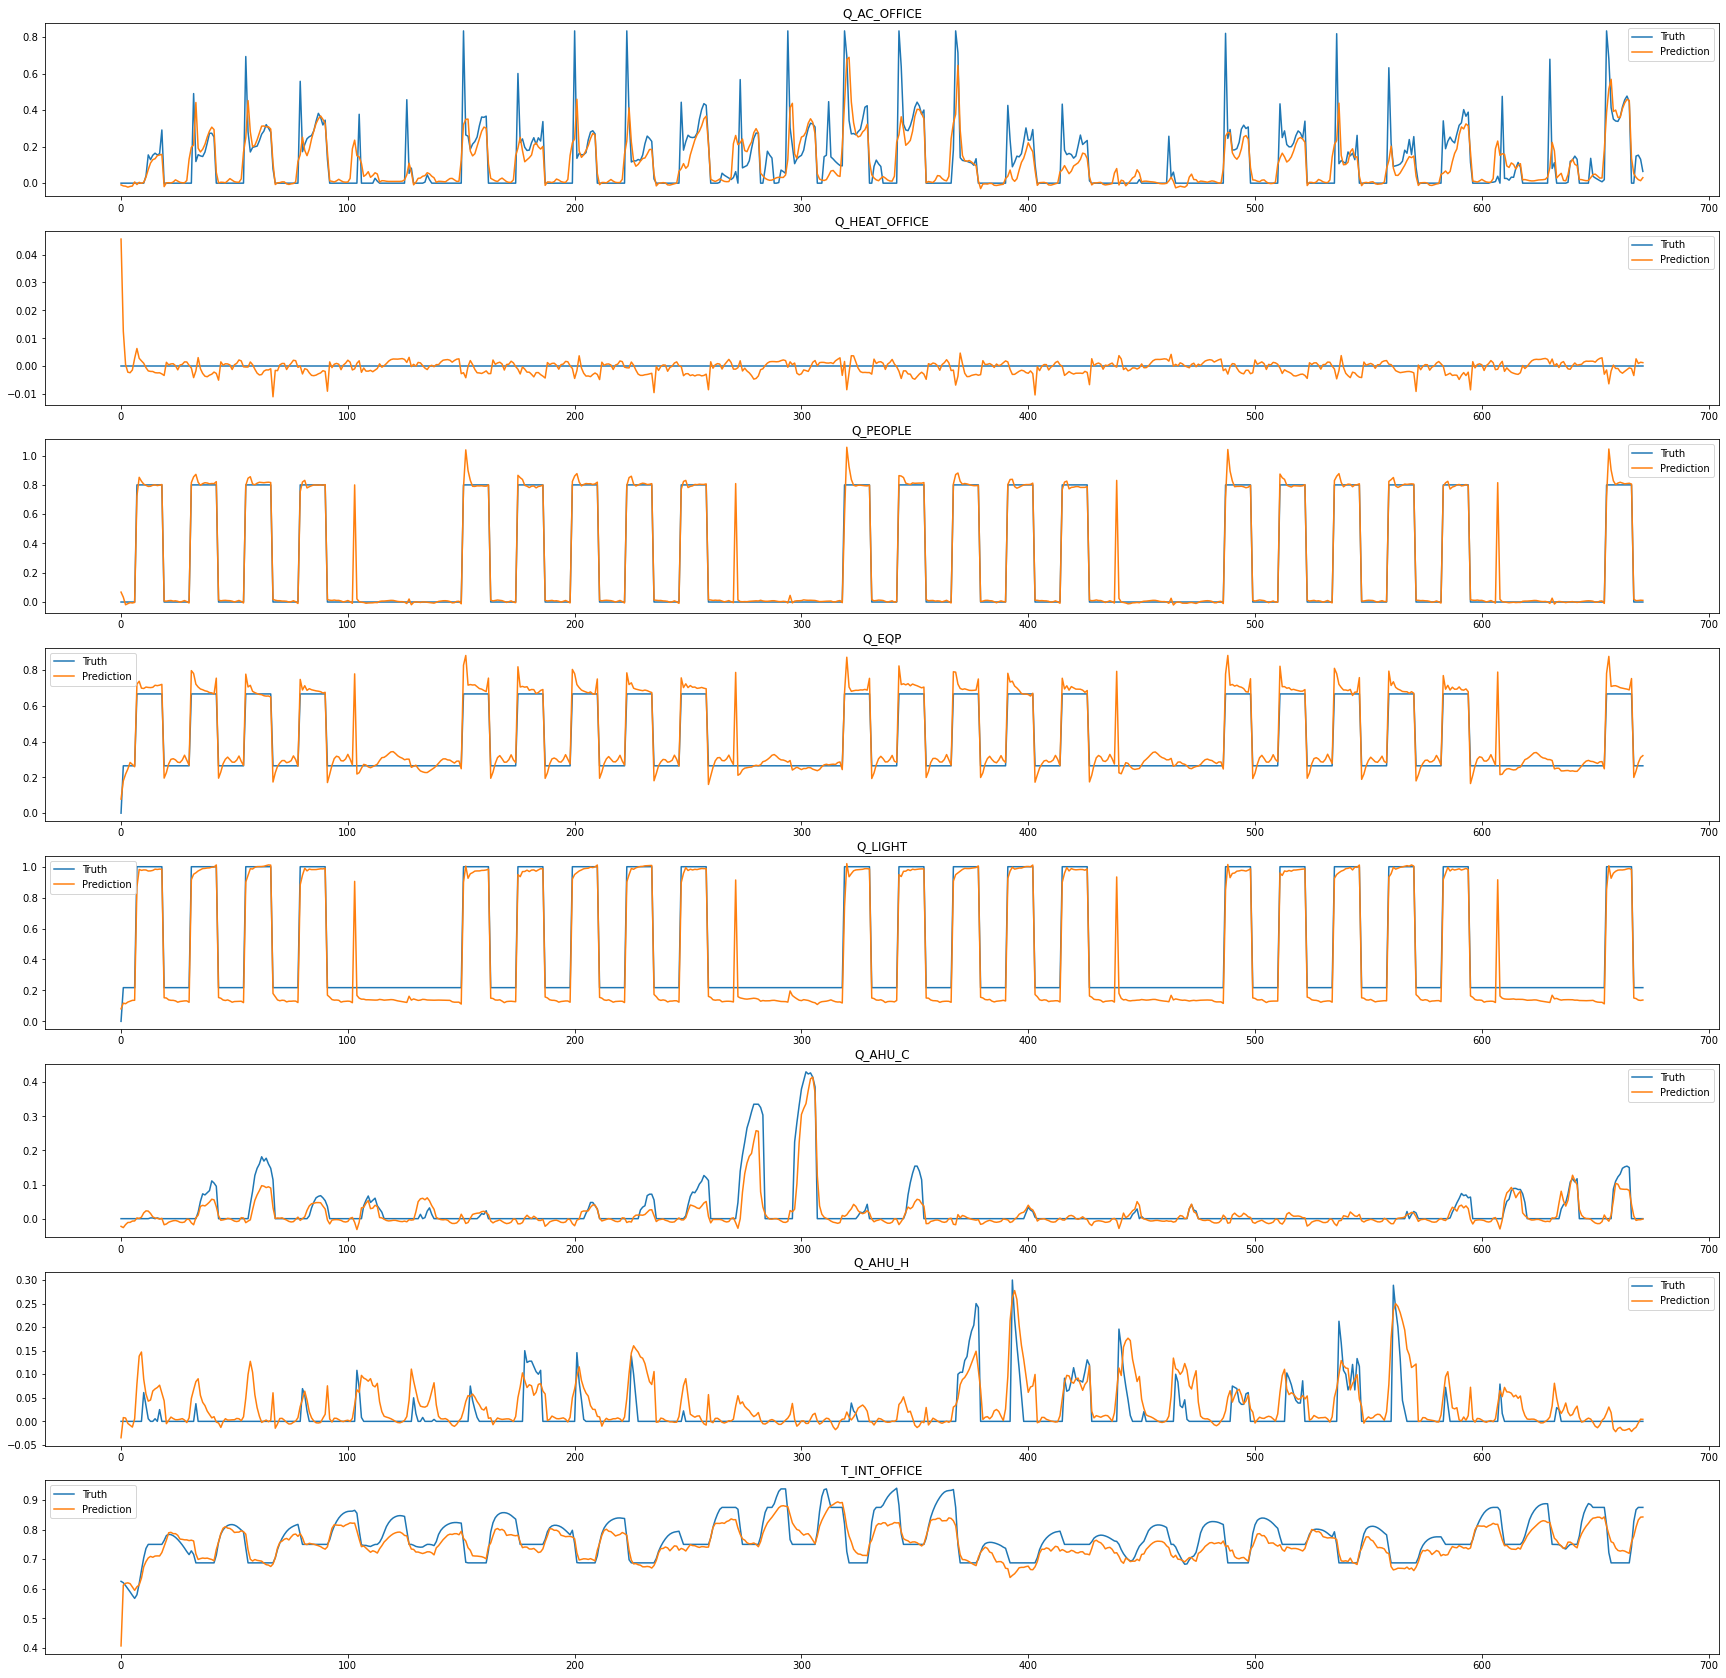

In [7]:
# Select training example
idx = np.random.randint(0, len(dataloader.dataset))
x, y = dataloader.dataset[idx]

# Run predictions
with torch.no_grad():
    x = torch.Tensor(x[np.newaxis, :, :])
    netout = net(x.to(device)).cpu().numpy()

plt.figure(figsize=(30, 30))
for idx_output_var in range(d_output):
    # Select real temperature
    y_true = y[:, idx_output_var]

    y_pred = netout[0, :, idx_output_var]

    plt.subplot(d_output, 1, idx_output_var+1)
    
    plt.plot(y_true, label="Truth")
    plt.plot(y_pred, label="Prediction")
    plt.title(dataloader.dataset.labels["X"][idx_output_var])
    plt.legend()
plt.savefig("fig")

# Evaluation

### Load evaluation dataset

In [8]:
dataset_eval = OzeEvaluationDataset("datasets/x_test_QK7dVsy.csv", K, labels_path="labels.json")
dataset_eval_length = len(dataset_eval)

### Run prediction

In [9]:
predictions = np.zeros((dataset_eval_length, K, d_output))
with torch.no_grad():
    for idx, line in tqdm(enumerate(dataset_eval), total=dataset_eval_length):
        # Run prediction
        netout = net(torch.Tensor(line[np.newaxis, :, :]).to(device)).cpu().numpy()
        
        # De-normalize output
        output = netout * (M - m + np.finfo(float).eps) + m
        predictions[idx] = output

100%|██████████| 500/500 [00:21<00:00, 23.67it/s]


### Export as csv

In [10]:
lines_output = predictions.reshape((dataset_eval_length, -1))
csv_header = [f"{var_name}_{k}" for var_name in dataset_eval.labels['X'] for k in range(K)]

df = pd.DataFrame(lines_output, columns=csv_header)
df.insert(0, 'index', df.index + len(dataset))
df.to_csv('y_bench.csv', index=False)